# Get gender

## Add `'gender'` key to database

In [1]:
import requests
from IPython.display import JSON
from gender_guesser_first_names import gender
from re import sub
from re import search
from re import UNICODE
import json
import country_converter as coco

In [266]:
LOCAL=False
if LOCAL:
    f=open('data/inspire_LA.json','r')
    df=json.load(f)
    f.close()
else:
    file ='https://github.com/restrepo/inspireauth/raw/main/data/inspire_LA.json'
    #file = 'https://github.com/restrepo/inspireauth/raw/e92dd3e002f6931ded19fb450b5238e09665b34b/data/inspire_LA.json'
    r=requests.get(file)
    df=r.json()

In [3]:
import pandas as pd

In [4]:
UPDATED = True
if UPDATED:
    TMP  = pd.DataFrame(df)
    TMPU = TMP.drop_duplicates('author_id').reset_index(drop=True)
    TMPUI = TMPU[TMPU['first_names'].apply(len)>0].reset_index(drop=True)
    TMPUA = TMPUI[TMPUI['gender_probability']>0.94].reset_index(drop=True)
    
    print(f'TOTAL: {TMP.shape[0]}')
    print(f'Unique autors: {TMPU.shape[0]}')
    print(f'''Remove first names with only intials: {TMPUI.shape[0]} = \
            male:  {TMPU[TMPU['gender']=='male'].shape[0]} + female: {
                    TMPU[TMPU['gender']=='female'].shape[0]} + unknown: {
                    TMPU[TMPU['gender']=='unknown'].shape[0]}.
             ''')
    print(f'Select found gender found probability from 95%: {TMPUA.shape[0]}')
    print(f'female ratio at probability at 95%: { 
                   round(TMPUA[TMPUA['gender']=='female'].shape[0]/(TMPUA[TMPUA['gender']=='female'].shape[0] + TMPUA[TMPUA['gender']=='male'].shape[0]),2)*100  }%')

TOTAL: 57588
Unique autors: 29979
Remove first names with only intials: 20125 =             male:  16013 + female: 3253 + unknown: 10713.
             
Select found gender found probability from 95%: 17634
female ratio at probability at 95%: 16.0%


Fill missing `author_id`s with `unknown` + counter 

In [29]:
DF = pd.DataFrame(df)
DFA = DF[~DF['author_id'].isna()]
DF.shape,DFA.shape

((57588, 15), (57588, 15))

In [30]:
unkown_prefix = 'unknown'
DFB = DF[DF['author_id'].isna()].reset_index(drop=True)
DFB['author_id']=[f'{unkown_prefix}{str(x).zfill(2)}' for x in range(DFB.shape[0])]

In [31]:
TMP = DFB[DFB.duplicated(subset='full_name',keep=False)].sort_values('author_id')

#https://saturncloud.io/blog/how-to-update-a-cell-value-in-pandas-dataframe
i_analysed = []
for i in TMP.index:
    if i not in i_analysed:
        print(i)
        # Extract each set of duplicates
        full_name = TMP.loc[i,'full_name']
        author_id = TMP.loc[i,'author_id']
        i_analysed = i_analysed + list(TMP.loc[TMP['full_name'] == full_name].index)
        DF.loc[ (DF['full_name'] == full_name) & (DF['author_id'].str.contains(unkown_prefix)) , 'author_id'] = author_id

del TMP

In [32]:
DF = pd.concat((DFA,DFB)).reset_index(drop=True)
del DFA
del DFB
DF.shape

(57588, 15)

Prepare names and countries for `gender_guesser` and [https://genderize.io](https://genderize.io) csv input

In [33]:
def remove_initials(d):
    '''
     Get names from `name.value` and if empty get it from `full_name`
     and using `country` information if avalaible
    '''
    if (d.get('name') and d.get('name').get('value') ):
        first_names = d.get('name').get('value').split(', ')[-1].replace('-',' ').strip()
    elif d.get('full_name'):
        first_names = d.get('full_name').split(', ')[-1].replace('-',' ').strip()
    else:
        first_names = ''
    x = first_names
    x = sub(r'[\|†•]','',x).strip()
    x = sub(r'\.',' ',   x, UNICODE).strip()
    x = sub(r'\s\w\s','',x, UNICODE).strip()
    x = sub(r'^\w\s','',x, UNICODE).strip()
    x = sub(r'\s\w$','',x, UNICODE).strip()
    x = sub(r'^\w$','',x, UNICODE).strip()
    x = sub(r'^[A-Z]{2}$','',x, UNICODE)
    
    return x

In [34]:
DF['names'] = DF.apply(lambda d: remove_initials(d), axis='columns')

In [35]:
DFU = DF[['country']].drop_duplicates()

In [36]:
DFU['country_id'] = DFU['country'].astype(str).replace('Serbia and Montenegro','Serbia').apply(lambda c: coco.convert(names=c, to='ISO2')).replace('not found','')

None not found in regex


In [37]:
DF = DF.merge(DFU,on='country',how='left')

In [38]:
del DFU

In [39]:
DF['country_id'].unique()[:2]

array(['VE', 'CL'], dtype=object)

In [40]:
DFU = DF[['author_id','names','country','country_id']].rename({'names':'name'},axis='columns').drop_duplicates('author_id').reset_index(drop=True)
DFU.shape

(29979, 4)

`gender_guesser`

In [41]:
D=gender.Detector(case_sensitive=False)
def force_get_gender(d,first_names='names'):
    '''
     Get names from `name.value` and if empty get it from `full_name`
     and using `country` information if avalaible
    '''
    gender = 'unknown'
    names = d.get(first_names)
    if names:
        if d.get('country'):
            gender = D.get_gender( names, country=d.get('country').strip() )
        else:
            gender = D.get_gender( names )
    return gender

In [42]:
DFU['gender'] = DFU.apply(lambda d: force_get_gender(d,first_names='name'), axis='columns')

In [43]:
DFU.shape

(29979, 5)

[https://genderize.io](https://genderize.io) csv input

In [44]:
DFUA = DFU[DFU['name'].apply(len)>0].reset_index(drop=True)
DFUB = DFU[DFU['name'].apply(len)==0].reset_index(drop=True)
DFU.shape[0], DFUA.shape[0], DFUB.shape[0],round( DFUB.shape[0] / DFU.shape[0],2)

(29979, 20125, 9854, 0.33)

In [45]:
DFUA.columns

Index(['author_id', 'name', 'country', 'country_id', 'gender'], dtype='object')

In [46]:
DFUA

,author_id,name,country,country_id,gender
0,H.Albrecht.1,Hartwig,Venezuela,VE,male
1,D.M.B.R.1,David Bellorin,Venezuela,VE,male
2,D.F.Mundarain.1,Douglas,Chile,CL,male
3,R.Gaitan.2,Rolando,Venezuela,VE,male
4,J.Ntahompagaze.1,Joseph,Rwanda,RW,male
...,...,...,...,...,...
20120,R.Weber.2,Ronald,Brazil,BR,male
20121,H.J.Drescher.1,Hans Joachim,Germany,DE,male
20122,A.A.P.Videira.1,AntonioP,Brazil,BR,unknown
20123,A.Mocsy.1,Agnes,United States,US,female


In [47]:
DFUA.shape

(20125, 5)

In [48]:
DFUA.to_csv('/home/restrepo/Downloads/genderize.csv',index=False)

Analysis of  [https://genderize.io](https://genderize.io) csv output

In [53]:
csv = 'data/genderize.csv'
DFUA = pd.read_csv(csv)

In [54]:
DFU = pd.concat((DFUA,DFUB)).reset_index(drop=True)

In [55]:
DFU['Gender'] = DFU['Gender'].fillna('unknown')
DFU['Gender Probability'] = DFU['Gender Probability'].fillna(0)
DFU['Gender Count'] = DFU['Gender Count'].fillna(0)
DFU[:1]

,author_id,name,country,country_id,gender,Gender,Gender Probability,Gender Count
0,H.Albrecht.1,Hartwig,Venezuela,VE,male,unknown,0.0,0.0


In [56]:
print('gender-guesser, genderize.io')
DFU[DFU['gender'].apply(lambda s: s in ['male','female'])].shape, DFU[DFU['Gender'].apply(lambda s: s in ['male','female'])].shape

gender-guesser, genderize.io


((16968, 8), (19266, 8))

Update official dataset

In [57]:
d_gender = dict(zip( DFU['author_id'], DFU['Gender'] ) )
d_first_names = dict(zip( DFU['author_id'], DFU.rename({'name':'first_names'},axis='columns')['first_names'] ) )
d_prob   = dict(zip( DFU['author_id'], DFU['Gender Probability'] ) )
unknown = DF[DF['author_id'].str.contains('unknown')]
d_author_id = dict(zip(unknown['full_name'],unknown['author_id']))

In [58]:
UPDATE = False
if UPDATE:
    for author_id in DFU['author_id']:
        kk = [d.update( {'first_names': d_first_names[author_id], 
                         'gender':      d_gender[author_id] ,
                         'gender_probability': d_prob[author_id]  } )
                  for d in df if d.get('author_id') == author_id]

In [6]:
TMP  = pd.DataFrame(df)
TMPU = TMP.drop_duplicates('author_id').reset_index(drop=True)
TMPUI = TMPU[TMPU['first_names'].apply(len)>0].reset_index(drop=True)
TMPUA = TMPUI[TMPUI['gender_probability']>0.9].reset_index(drop=True)

print(f'TOTAL: {TMP.shape[0]}')
print(f'Unique autors: {TMPU.shape[0]}')
print(f'''Remove first names with only intials: {TMPUI.shape[0]} = \
        male:  {TMPU[TMPU['gender']=='male'].shape[0]} + female: {
                TMPU[TMPU['gender']=='female'].shape[0]} + unknown: {
                TMPU[TMPU['gender']=='unknown'].shape[0]}.
         ''')
print(f'Select found gender found probability from 95%: {TMPUA.shape[0]}')
print(f'female ratio at probability at 95%: { 
               round(TMPUA[TMPUA['gender']=='female'].shape[0]/(TMPUA[TMPUA['gender']=='female'].shape[0] + TMPUA[TMPUA['gender']=='male'].shape[0]),2)*100  }%')

TOTAL: 57588
Unique autors: 29979
Remove first names with only intials: 20125 =         male:  16013 + female: 3253 + unknown: 10713.
         
Select found gender found probability from 95%: 17954
female ratio at probability at 95%: 16.0%


In [59]:
TMP  = pd.DataFrame(df)
TMPU = TMP.drop_duplicates('author_id').reset_index(drop=True)
TMPUI = TMPU[TMPU['first_names'].apply(len)>0].reset_index(drop=True)
TMPUA = TMPUI[TMPUI['gender_probability']>0.94].reset_index(drop=True)

print(f'TOTAL: {TMP.shape[0]}')
print(f'Unique autors: {TMPU.shape[0]}')
print(f'''Remove first names with only intials: {TMPUI.shape[0]} = \
        male:  {TMPU[TMPU['gender']=='male'].shape[0]} + female: {
                TMPU[TMPU['gender']=='female'].shape[0]} + unknown: {
                TMPU[TMPU['gender']=='unknown'].shape[0]}.
         ''')
print(f'Select found gender found probability from 95%: {TMPUA.shape[0]}')
print(f'female ratio at probability at 95%: { 
               round(TMPUA[TMPUA['gender']=='female'].shape[0]/(TMPUA[TMPUA['gender']=='female'].shape[0] + TMPUA[TMPUA['gender']=='male'].shape[0]),2)*100  }%')

TOTAL: 57588
Unique autors: 29979
Remove first names with only intials: 20125 =         male:  16013 + female: 3253 + unknown: 10713.
         
Select found gender found probability from 95%: 17634
female ratio at probability at 95%: 16.0%


In [60]:
DUMP = False
if DUMP:
    f=open('data/inspire_LA.json','w')
    json.dump(df,f)
    f.close()

Check test dataset with [https://genderize.io](https://genderize.io)

In [114]:
COT = pd.read_json('https://raw.githubusercontent.com/colav-playground/gender_guesser_first_names/refs/heads/main/data/test_gender.json')
COT.shape

(3967, 3)

In [117]:
COT[:681].to_csv('data/test_gender_NC.csv',index = False)

In [113]:
UPDATE_CO = False
if UPDATE_CO:
    CO = COT.copy()
    CO = pd.read_json('https://raw.githubusercontent.com/colav-playground/gender_guesser_first_names/refs/heads/main/data/test_gender.json')
    CO['country_id'] = CO['country'].astype(str).apply(lambda c: coco.convert(names=c, to='ISO2')).replace('not found','')
    CO[CO['country'] == 'other_countries'].to_csv('/home/restrepo/Downloads/test_gender2.csv',index=False)
    CO.to_csv('/home/restrepo/Downloads/test_gender.csv',index=False)

Analysis of  [https://genderize.io](https://genderize.io) test csv output

In [50]:
UPDATE_OC = False
if UPDATE_OC:
    COLD = pd.read_csv('data/test_gender2.csv')    
    CO = pd.read_csv('data/test_gender.csv')
    
    CO = CO[CO['gender']!='L'].reset_index(drop=True)
    
    CO1 = CO[CO['country'] != 'other_countries'].reset_index(drop=True)
    CO2 = CO[CO['country'] == 'other_countries'].reset_index(drop=True)
    CO.shape[0], CO1.shape[0] + CO2.shape[0] 
    
    CO2 = CO2[['names', 'gender', 'country', 'country_id']].merge(
         COLD[['names', 'Gender','Gender Probability', 'Gender Count']],
                on = 'names', how = 'left').fillna('')
    
    CO = pd.concat((CO1,CO2)).reset_index(drop=True)
    CO.to_csv('data/test_gender.csv',index=False)

In [129]:
CO = pd.read_csv('data/test_gender.csv')
#CO = pd.read_csv('data/test_gender_NC631.csv')

confusion matrix

In [130]:
CM = {'male':{},'female':{}}

In [131]:
for i in ['male','female']:
    for j in ['male','female','unknown']:
        CM[i][j] = CO[ (CO['gender'] == i) & (CO['Gender'] == j)].shape[0]

In [132]:
CO90 = CO.copy(deep=True)
CO90['Gender'] = CO.apply(lambda d: 'unknown' if d['Gender Probability'] < 0.9 else d['Gender'],axis = 'columns')

In [134]:
CM90 = {'male':{},'female':{}}
for i in ['male','female']:
    for j in ['male','female','unknown']:
        CM90[i][j] = CO90[ (CO90['gender'] == i) & (CO90['Gender'] == j)].shape[0]

In [150]:
def error(CM):
    return (CM['male']['female'] + CM['female']['male'])/(
            CM['male']['male'] + CM['female']['female'] + CM['male']['female'] + CM['female']['male'])
def accuracy(CM):
    return (CM['male']['male'] + CM['female']['female'])/(
            CM['male']['male'] + CM['female']['female'] + CM['male']['female'] + CM['female']['male'])


def errorNA(CM):
    return (CM['male']['female'] + CM['female']['male'] + CM['male']['unknown'] + CM['female']['unknown'] )/(
            CM['male']['male'] + CM['female']['female'] + CM['male']['female'] + CM['female']['male'] + 
            CM['male']['unknown'] + CM['female']['unknown'])
def postitivity(CM,category='male'):
    # False positive (FP) denotes the number of samples incorrectly classified as positive. 
    # False negative (FN) denotes the number of samples incorrectly classified as negative.
    if category == 'male':
        anti_category = 'female'
    else:
        anti_category = 'male'
        
    return (CM[category][category])/(
            CM[category][category] + CM[anti_category][category])    # FP
def recall(CM,category='male'):
    if category == 'male':
        anti_category = 'female'
    else:
        anti_category = 'male'
        
    return (CM[category][category])/(
            CM[category][category] + CM[category][anti_category])    #FN


print( f'error {error(CM)*100} %' )
print( f'accuracy {accuracy(CM)*100} %  → {error(CM) + accuracy(CM)}' )
print( f'errorNA {errorNA(CM)*100} %' )
print( f'positivity {postitivity(CM)*100}%   {postitivity(CM,category="female")*100}%'   )
print( f'recall {recall(CM)*100}% {recall(CM,category="female")*100}%' )

error 0.8379888268156425 %
accuracy 99.16201117318437 %  → 1.0
errorNA 1.5132408575031526 %
positivity 99.13710450623202%   99.19006479481641%
recall 99.27988478156506% 99.02964959568733%


In [138]:
postitivity(CM) + error(CM)

1.0

In [151]:
print( f'error90 {error(CM90)*100}%' )
print( f'accuracy90 {accuracy(CM90)*100} %  → {error(CM) + accuracy(CM)}' )
print( f'errorNA90 {errorNA(CM90)*100}%')

error90 0.6168080185042405%
accuracy90 99.38319198149576 %  → 1.0
errorNA90 2.471626733921816%


In [107]:
error(CM90)*100

0.6168080185042405

In [96]:
i = 'male'
j = 'unknown'
CO90[ (CO90['gender'] == i) ]

,names,gender,country,country_id,Gender,Gender Probability,Gender Count
1,Jefferson Alejandro,male,colombia,CO,male,1.00,17
2,Jhon Jairo,male,colombia,CO,male,1.00,19782
9,Jose Luis,male,colombia,CO,male,1.00,15204
10,Danilo,male,colombia,CO,male,1.00,12188
13,Francisco Ivan,male,colombia,CO,male,1.00,37775
...,...,...,...,...,...,...,...
3955,Volodymyr,male,other_countries,NaN,male,1.00,2958
3961,Florian Jan Fietje,male,other_countries,NaN,unknow,0.89,343839
3962,Yaniel,male,other_countries,NaN,male,0.98,592
3963,Lars Fredrik,male,other_countries,NaN,male,1.00,7


In [15]:
COK = CO[ CO['Gender'] != 'unknown'] # male or female


In [16]:
COW = COK[  (COK['gender'] != COK['Gender']) ]
print(f'Number of errors: {COW.shape[0]}')
print( f'Error: {round(COW.shape[0]/COK.shape[0]*100,2)} %. Includes low Gender Probability')

Number of errors: 33
Error: 0.84 %. Includes low Gender Probability


In [19]:
precision = 0.9
good_quality = COK[(COK['Gender Probability'] >= precision)].shape[0]
wrong_good_quality = COK[(COK['Gender Probability'] >= precision) & (COK['gender'] != COK['Gender'])].shape[0]
bad_quality = COK[(COK['Gender Probability'] < precision)].shape[0]
wrong_bad_quality = COK[(COK['Gender Probability'] < precision) & (COK['gender'] != COK['Gender'])].shape[0]

In [20]:
print(f'good_quality_error: {round(wrong_good_quality/good_quality*100,2)} %' )
print(f'bad_quality_error : {round( wrong_bad_quality/ bad_quality*100,2)} %' )

good_quality_error: 0.62 %
bad_quality_error : 19.15 %


with `precision = 0.95`:

good_quality_error: 0.57 %

bad_quality_error : 11.22 %

Conclusion: Is important to guarantee good quality

In [229]:
print(f'female ratio: {round(CO[CO['Gender']=='female'].shape[0]/(CO[CO['Gender']=='female'].shape[0] + CO[CO['Gender']=='male'].shape[0]),2)*100} %')

female ratio: 47.0 %


In [231]:
print(f'unknowns: {CO[ CO['Gender'] == 'unknown'].shape[0]}')
print(f'unknown: {round(CO[ CO['Gender'] == 'unknown'].shape[0]/CO.shape[0]*100,2)} %')

unknowns: 27
unknown: 0.68 %


## Analysis

In [1]:
import pandas as pd
import requests
from datetime import datetime

def get_published_ranks(positions,year):
    ranks = []
    if not isinstance(positions,list):
        return ranks
    if not year:
        return ranks
    for d in positions:
        if not d.get('end_date'):
            end_date = datetime.now().year
        else:
            end_date = int(d.get('end_date').split('-')[0])

        if not d.get('start_date'): # bad position
            continue
        else:
            start_date = int(d.get('start_date').split('-')[0])
        if year >= start_date and year <= end_date:
            ranks.append(d.get('rank'))
    return list(set(ranks))

In [2]:
DF = pd.read_json('data/inspire_LA.json',dtype={'institution_id':str, 'author_id':str})

In [3]:
#DF = pd.DataFrame(df)

Test: Colombia

In [4]:
#DF = pd.read_json('data/inspire_LA.json')

Unique authors ids

In [5]:
DF['author_id'].unique().shape # → 29979

(29979,)

In [6]:
#DF[DF['gender'].apply(lambda g: g in ['male','female'])]

In [3]:
DF.dropna(subset=['positions'])['author_id'].unique().shape # → 11315

(11315,)

In [4]:
kk = DF[['institution_id','country']].to_dict(orient = 'list')
dc = dict(zip( [x if isinstance(x,str) else x for x in kk['institution_id']], kk['country']))
kk = DF[['institution_id','institution']].to_dict(orient = 'list')
di = dict(zip( [x if isinstance(x,str) else x for x in kk['institution_id']], kk['institution']))

### General counts

In [5]:
#dp = pd.DataFrame(flatten_list(DF['papers'].to_list()))

In [6]:
dp = pd.DataFrame(DF.papers.apply(pd.Series).stack().to_list()).reset_index(
        drop=True
    )

In [7]:
dp['year'] = dp['year'].fillna(0).astype(str).str.replace('None','0').astype(int)

In [8]:
dp.shape # → 886011

(886011, 13)

In [9]:
dp['country'] =  dp.apply(lambda d: str(d['country']).replace('nan',str(dc.get( d['institution_id']))
                                   ).replace('None',str(dc.get( d['institution_id']))
                                            ),axis='columns')

In [10]:
dp['institution'] =  dp.apply(lambda d: str(d['institution']).replace('nan',str(di.get( d['institution_id']))
                                   ).replace('None',str(di.get( d['institution_id']))
                                            ),axis='columns')

In [11]:
dp[:3]

,recid,year,citation_count,primary_arxiv_category,journal_id,author_id,institution_id,rank,start_date,end_date,institution,country,current
0,2023395,2021,1,[quant-ph],None,H.Albrecht.1,912061,NaN,NaN,NaN,"Unlisted, VE",Venezuela,NaN
1,2068608,2022,0,[quant-ph],None,H.Albrecht.1,912061,NaN,NaN,NaN,"Unlisted, VE",Venezuela,NaN
2,2023395,2021,1,[quant-ph],None,D.M.B.R.1,912061,NaN,NaN,NaN,"Unlisted, VE",Venezuela,NaN


recid = 1375014
url = f'https://inspirehep.net/api/literature?q=recid:{recid}'
r = requests.get(url)

In [12]:
dp.shape # → 886011

(886011, 13)

Unique papers

In [13]:
dp[dp['recid'].astype(str).str.contains(r'^[0-9]{3,6}')].shape

(886011, 13)

In [14]:
dp[dp['recid'] == 1736716]

,recid,year,citation_count,primary_arxiv_category,journal_id,author_id,institution_id,rank,start_date,end_date,institution,country,current
734064,1736716,2019,12,[hep-th],1214648,V.I.Yukalov.1,902780,NaN,NaN,NaN,"Dubna, JINR",Russian Federation,NaN
734065,1736716,2019,12,[hep-th],1214648,V.I.Yukalov.1,903186,NaN,NaN,NaN,Sao Paulo U.,Brazil,NaN
734404,1736716,2019,12,[hep-th],1214648,V.I.Yukalov.1,902780,NaN,NaN,NaN,"Dubna, JINR",Russian Federation,NaN
734405,1736716,2019,12,[hep-th],1214648,V.I.Yukalov.1,903186,NaN,NaN,NaN,Sao Paulo U.,Brazil,NaN
734427,1736716,2019,12,[hep-th],1214648,V.I.Yukalov.1,902780,NaN,NaN,NaN,"Dubna, JINR",Russian Federation,NaN
734428,1736716,2019,12,[hep-th],1214648,V.I.Yukalov.1,903186,NaN,NaN,NaN,Sao Paulo U.,Brazil,NaN
790017,1736716,2019,12,[hep-th],1214648,V.I.Yukalov.1,902780,NaN,NaN,NaN,"Dubna, JINR",Russian Federation,NaN
790018,1736716,2019,12,[hep-th],1214648,V.I.Yukalov.1,903186,NaN,NaN,NaN,Sao Paulo U.,Brazil,NaN
804034,1736716,2019,12,[hep-th],1214648,V.I.Yukalov.1,902780,NaN,NaN,NaN,"Dubna, JINR",Russian Federation,NaN
804035,1736716,2019,12,[hep-th],1214648,V.I.Yukalov.1,903186,NaN,NaN,NaN,Sao Paulo U.,Brazil,NaN


Check Country

In [19]:
country = 'Brazil'
Test = True
if Test:
    #All papers 2024
    c = requests.get(f'https://inspirehep.net/api/institutions?sort=mostrecent&size=250&page=1&q={country}')
    print(sum( [d['metadata']['number_of_papers'] for d in c.json()['hits']['hits'] ]))

66771


In [15]:
dp.drop_duplicates('recid').shape # → 49181

(49181, 13)

In [16]:
#dp = dp[~dp['author_id'].isna()].reset_index(drop=True)

We must remove all duplicated authors and multiple affiliations for each `recid` entry:

In [17]:
#dp_old = dp.copy()

In [18]:
dp = dp.drop_duplicates(subset=['recid', 'year','journal_id', 'author_id','institution_id']).reset_index(drop=True)

In [19]:
dp.shape # → 173946

(173946, 13)

In [20]:
dp = dp.merge(DF.drop_duplicates('author_id')[['author_id','full_name','name', 'positions',
       'profile_id', 'advisors', 'gender', 'first_names',
       'gender_probability']],on = 'author_id',how ='left')

In [21]:
pd.set_option('display.max_columns', 500)

In [22]:
dp.shape

(173946, 21)

Example with female coauthor

In [23]:
dp[dp['recid'] == 1736716]

,recid,year,citation_count,primary_arxiv_category,journal_id,author_id,institution_id,rank,start_date,end_date,institution,country,current,full_name,name,positions,profile_id,advisors,gender,first_names,gender_probability
160210,1736716,2019,12,[hep-th],1214648,V.I.Yukalov.1,902780,NaN,NaN,NaN,"Dubna, JINR",Russian Federation,NaN,"Yukalov, V.I.","{'value': 'Yukalov, Vyacheslav I.', 'preferred...","[{'rank': 'SENIOR', 'record': {'$ref': 'https:...",982494.0,"[{'name': 'Bogolubov, N.N.', 'degree_type': 'o...",male,Vyacheslav,1.0
160211,1736716,2019,12,[hep-th],1214648,V.I.Yukalov.1,903186,NaN,NaN,NaN,Sao Paulo U.,Brazil,NaN,"Yukalov, V.I.","{'value': 'Yukalov, Vyacheslav I.', 'preferred...","[{'rank': 'SENIOR', 'record': {'$ref': 'https:...",982494.0,"[{'name': 'Bogolubov, N.N.', 'degree_type': 'o...",male,Vyacheslav,1.0


Quality control

<Axes: xlabel='year'>

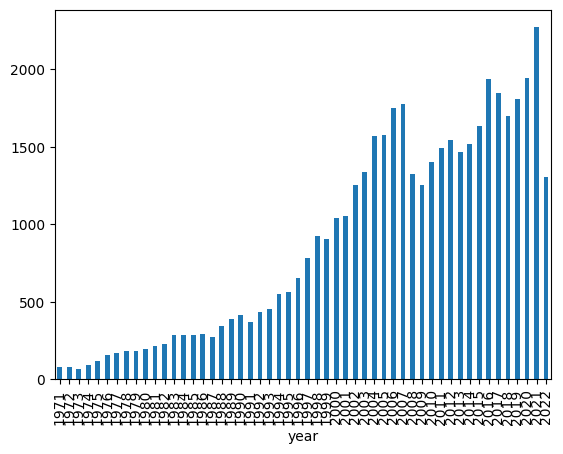

In [24]:
dpc = dp.drop_duplicates('recid').reset_index(drop = True) 
dpc[dpc['year']>1970]['year'].replace('None',0).astype(int).value_counts().sort_index().plot(kind='bar')

Pick country

In [28]:
country = 'Chile'
dp[dp['country'] == country].drop_duplicates('recid').shape # → 24962

(6396, 21)

In [54]:
dpla = dp.drop_duplicates('recid').reset_index(drop = True)
dpla.shape

(49181, 21)

In [29]:
dpc = dp[dp['country'] == country].reset_index(drop = True) # Include repeated recid from coauthors of the same country
dpc = dpc.drop_duplicates('recid').reset_index(drop = True) # papers from a country from some coauthor
dpc.shape

(6396, 21)

<Axes: xlabel='year'>

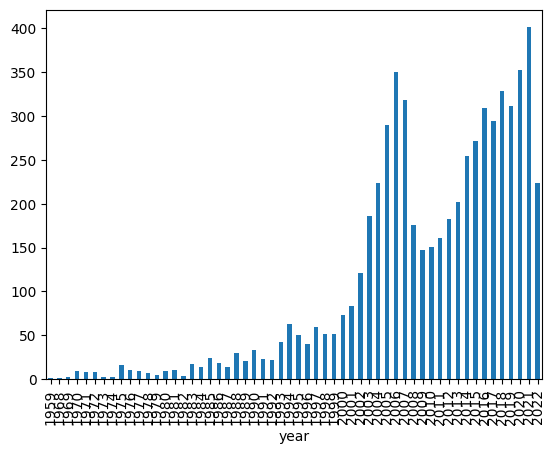

In [31]:
dpc[dpc['year']>0]['year'].replace('None',0).astype(int).value_counts().sort_index().plot(kind='bar')

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

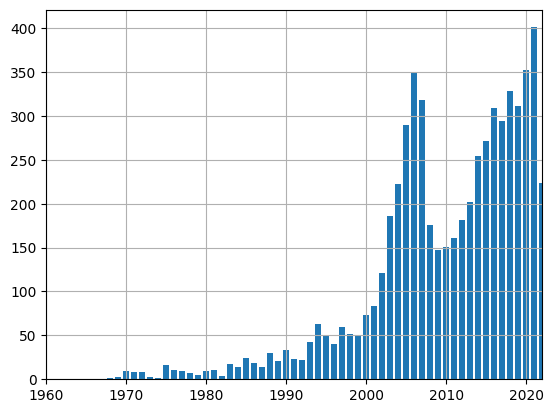

In [33]:
plt.bar( dpc[dpc['year']>0]['year'].replace('None',0).astype(int).value_counts().sort_index().to_dict().keys(),
        dpc[dpc['year']>0]['year'].replace('None',0).astype(int).value_counts().sort_index().to_dict().values())
plt.xlim(1960,2022)
plt.grid()

In [52]:
dp.columns

Index(['recid', 'year', 'citation_count', 'primary_arxiv_category',
       'journal_id', 'author_id', 'institution_id', 'rank', 'start_date',
       'end_date', 'institution', 'country', 'current', 'full_name', 'name',
       'positions', 'profile_id', 'advisors', 'gender', 'first_names',
       'gender_probability'],
      dtype='object')

In [43]:
dpc[dpc['primary_arxiv_category'].apply(len)>1].shape

(0, 21)

In [66]:
#print(
dpc['primary_arxiv_category'].str[0].fillna('None').value_counts()[:16]#.to_latex())

primary_arxiv_category
hep-th               1454
astro-ph             1189
None                 1135
hep-ph               1107
gr-qc                 881
astro-ph.CO           154
quant-ph               70
astro-ph.GA            66
math-ph                61
nucl-th                58
astro-ph.HE            44
astro-ph.SR            24
cond-mat.mes-hall      22
physics.gen-ph         14
cond-mat               10
astro-ph.IM            10
Name: count, dtype: int64

<Axes: xlabel='year'>

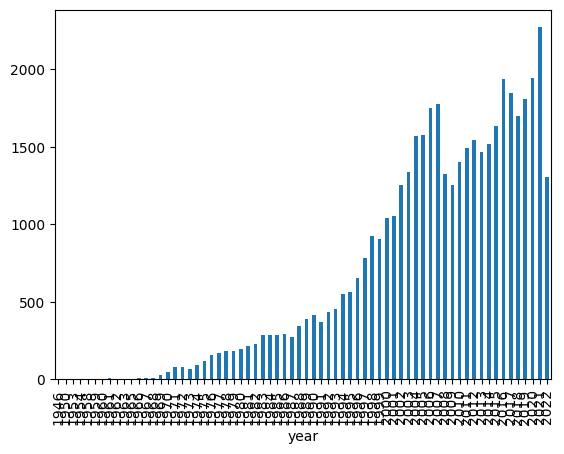

In [55]:
dpla[dpla['year']>0]['year'].replace('None',0).astype(int).value_counts().sort_index().plot(kind='bar')

In [59]:
dpla[dpla['primary_arxiv_category'].apply(len)>1].shape

(3, 21)

In [70]:
dpla[dpla['primary_arxiv_category'].str[0].fillna('None') == 'None'].sample().iloc[0]

recid                                                               1858827
year                                                                   2021
citation_count                                                            0
primary_arxiv_category                                                   []
journal_id                                                             None
author_id                                                 G.Sanchez.Colon.1
institution_id                                                       906374
rank                                                                    NaN
start_date                                                              NaN
end_date                                                                NaN
institution                                                     Merida, IPN
country                                                              Mexico
current                                                                 NaN
full_name   

In [74]:
print(
dpla['primary_arxiv_category'].str[0].fillna('None').value_counts()[:19].to_latex())

\begin{tabular}{lr}
\toprule
 & count \\
primary_arxiv_category &  \\
\midrule
None & 16946 \\
hep-th & 8616 \\
hep-ph & 6941 \\
gr-qc & 6058 \\
astro-ph & 3564 \\
nucl-th & 1365 \\
quant-ph & 1169 \\
astro-ph.CO & 907 \\
math-ph & 620 \\
astro-ph.HE & 545 \\
cond-mat.stat-mech & 214 \\
hep-lat & 197 \\
cond-mat & 191 \\
physics.gen-ph & 181 \\
astro-ph.GA & 158 \\
hep-ex & 135 \\
cond-mat.str-el & 133 \\
physics & 124 \\
cond-mat.mes-hall & 118 \\
\bottomrule
\end{tabular}



In [35]:
dp['gender_probability'] = dp['gender_probability'].fillna(0)

In [36]:
dp['gender'] = dp['gender'].fillna('unknown')

In [37]:
dp.gender.unique()

array(['unknown', 'male', 'female'], dtype=object)

In [38]:
dp['ranks_year'] = dp.apply(lambda r: get_published_ranks(r['positions'],r['year']) ,axis = 'columns')
dp[dp['ranks_year'].apply(len)>0].shape # → 46047

(46047, 22)

In [39]:
UPDATE_genders = False
if UPDATE_genders:
    dp.to_json('data/papers.json.gz',orient = 'records')
else:
    dp = pd.read_json('data/papers.json.gz')

In [40]:
dp.shape

(173946, 22)

Check against  countries count from the paper

In [41]:
dp[dp['country'] != 'None'].shape

(172883, 22)

In [42]:
c = 'Chile'
dpc = dp[dp['country'] == c].drop_duplicates('recid')

In [43]:
dpc.shape

(6396, 22)

<Axes: xlabel='year'>

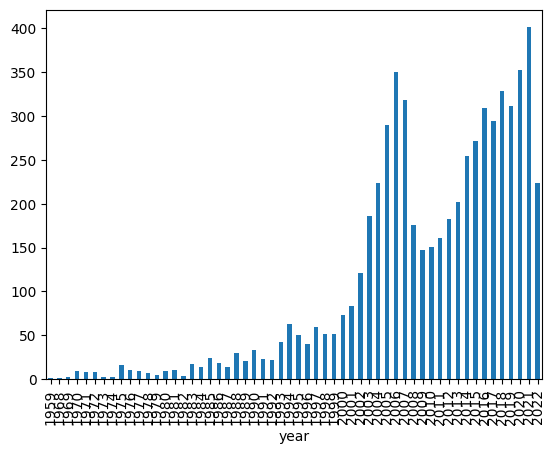

In [44]:
dpc[dpc['year']>0]['year'].replace('None',0).astype(int).value_counts().sort_index().plot(kind='bar')

In [45]:
DPC = pd.read_json(f'exports/{c.lower()}_papers.json')

In [46]:
DPC.shape # → 6396

(6396, 13)

In [47]:
len(DPC['recid'].unique())

6396

In [48]:
len(set(dpc['recid']).intersection(DPC['recid']))

6396

In [49]:
mb = list(set(DPC['recid']).difference(dpc['recid']))

In [50]:
len(mb)

0

## Gender

For each year remove duplicate authors  → unique authors of LA papers each year

In [52]:
dpa = dp.drop_duplicates(subset=['year','author_id']).reset_index(drop=True)
dpa.shape # → 82638

(82638, 22)

In [53]:
dpu = dpa[dpa['gender_probability'] >= 0.9].reset_index(drop=True)

In [54]:
dpu.shape # → 55394

(55394, 22)

In [106]:
(dp.drop_duplicates('author_id').shape[0],
 dpa.drop_duplicates('author_id').shape[0],
 dpu.drop_duplicates('author_id').shape[0])

(29969, 29969, 18010)

In [173]:
def fraction(df):
    return df[df['gender'] == 'female'].shape[0]/df.shape[0]
import math as m
def margin_of_error(p,n, Z = 1.96):
    #https://en.wikipedia.org/wiki/Margin_of_error
    #Z  = 1.96 # for a 95% confidence level
    if n != 0:
        ME =  Z * m.sqrt(p*(1-p)/n)
    else:
        ME =  1
    return ME
    
def plot_gender(dpup, ymin = 1972, ymax = 2022,file='f_m_evolution'):

    gry = []
    for y in dpup['year'].unique():
        dpuy = dpup[dpup['year'] == y].reset_index(drop=True)
        dgry =             {'year': y, 'authors': dpuy.shape[0], 
             'articles': dpuy.drop_duplicates('recid').shape[0],
             'male':   dpuy[dpuy['gender'] == 'male'].shape[0],
             'female': dpuy[dpuy['gender'] == 'female'].shape[0],
             'fraction': fraction(dpuy)
            }
        p = dgry['fraction']
        n = dgry['authors'] # "male" + "female"
        dgry['ME'] = margin_of_error(p,n)
        gry.append(dgry)
        
    dy = pd.DataFrame(gry).sort_values('year')
    dy = dy[dy['year'] > 0].reset_index(drop=True) #only published
    plt.subplot(2,1,1)
    dymm = dy[ (dy['year'] > ymin) & (dy['year'] < ymax) ]
    plt.plot(dymm['year'],dymm['authors'],'k')
    plt.plot(dymm['year'],dymm['authors'],'r.')
    plt.ylabel('year',size = 12)
    plt.ylabel('Unique authors',size = 12)
    plt.grid()
    plt.subplot(2,1,2)
    #ymin = 1972
    plt.plot(dymm['year'],dymm['fraction'],'k')
    plt.plot(dymm['year'],dymm['fraction'],'r.')
    plt.ylabel('Female fraction',size = 12)
    plt.xlabel('year',size = 12)
        
    # Margin of Error
    #plt.plot(dymm['year'],dymm['fraction']+dymm['ME'])
    #plt.plot(dymm['year'],dymm['fraction']-dymm['ME'])
    plt.fill_between(dymm['year'],dymm['fraction']-dymm['ME'],dymm['fraction']+dymm['ME'],alpha=0.2)
    plt.grid()

    plt.savefig(f'{file}.pdf')
    
    return dy

In [146]:
%matplotlib inline
import matplotlib.pyplot as plt

In [147]:
#dy = plot_gender(dp,ymin=1978)

In [148]:
dpu[dpu['year'] == 2021].shape[0],dpu[dpu['year'] == 2021].drop_duplicates('author_id').shape[0]

(3486, 3486)

In [149]:
dpu[dpu['year'] == 2021].shape[0],dpu[dpu['year'] == 2021].drop_duplicates('recid').shape[0]

(3486, 1621)

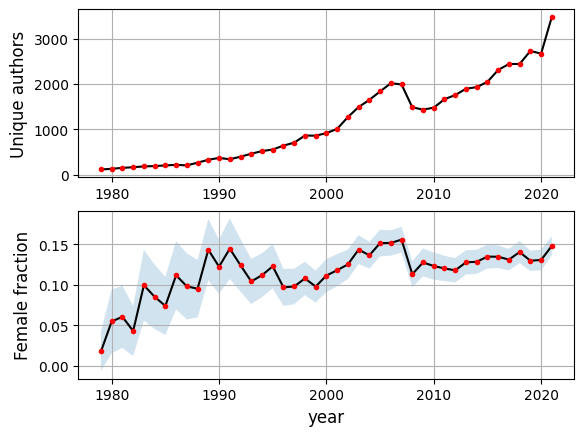

In [174]:
dy = plot_gender(dpu,ymin=1978)

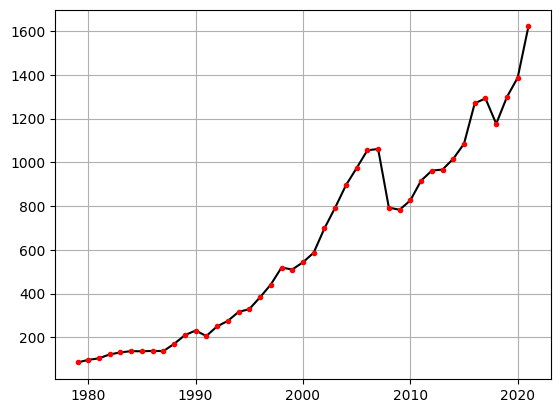

In [144]:
ymin = 1978
ymax = 2022
plt.plot(dy[(dy['year'] > ymin) & (dy['year'] < ymax)]['year'],
         dy[(dy['year'] > ymin) & (dy['year'] < ymax)]['articles'],'k')
plt.plot(dy[(dy['year'] > ymin) & (dy['year'] < ymax)]['year'],
         dy[(dy['year'] > ymin) & (dy['year'] < ymax)]['articles'],'r.')
plt.grid()

In [66]:
dpup = dpu[dpu['positions'].apply(lambda L: isinstance(L,list))].reset_index(drop=True)

In [67]:
dpu.shape, dpup.shape , dpup[dpup['positions'].apply(len)>0].shape

((55394, 22), (41315, 22), (41315, 22))

In [68]:
kk = dpup.drop_duplicates('author_id')
(fraction(kk)-margin_of_error(fraction(kk),kk.shape[0]), 
 fraction(kk)+margin_of_error(fraction(kk),kk.shape[0]))

(0.12971201033290214, 0.14332204222870948)

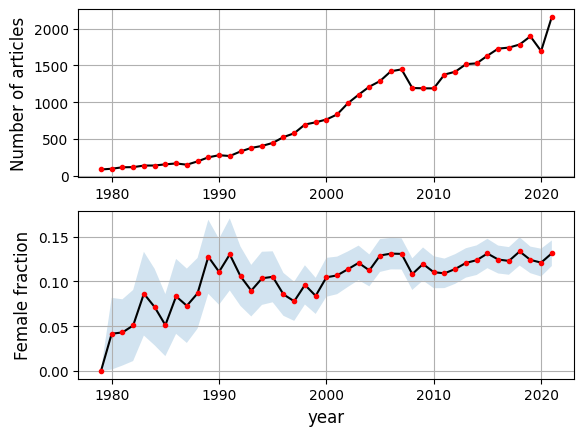

In [69]:
dy = plot_gender(dpup,ymin=1978)

In [70]:
dpup['ranks'] = dpup['positions'].apply(lambda L: list(set([d.get('rank') for d in L if d.get('rank')])))

In [151]:
ranks = 'ranks_year' # rank in publications year
#ranks = 'ranks' # rank in profile
dpups = dpup[dpup[ranks].apply(lambda L:  len({'PHD','UNDERGRADUATE','MASTER'}.intersection(L))>0 )].reset_index(drop=True)
dpupp = dpup[dpup[ranks].apply(lambda L:  len({'POSTDOC'}.intersection(L))>0 )].reset_index(drop=True)
dpupj = dpup[dpup[ranks].apply(lambda L:  len({'JUNIOR','STAFF'}.intersection(L))>0 )].reset_index(drop=True)
dpupS = dpup[dpup[ranks].apply(lambda L:  len({'SENIOR'}.intersection(L))>0 )].reset_index(drop=True)

In [169]:
kk = dpups.drop_duplicates('author_id')
print(f'{round(fraction(kk),3)}  ± {round(margin_of_error(fraction(kk),kk.shape[0]),3)}')
(fraction(kk)-margin_of_error(fraction(kk),kk.shape[0]), 
 fraction(kk)+margin_of_error(fraction(kk),kk.shape[0]))

0.144  ± 0.019


(0.12423443446508925, 0.16283181159169308)

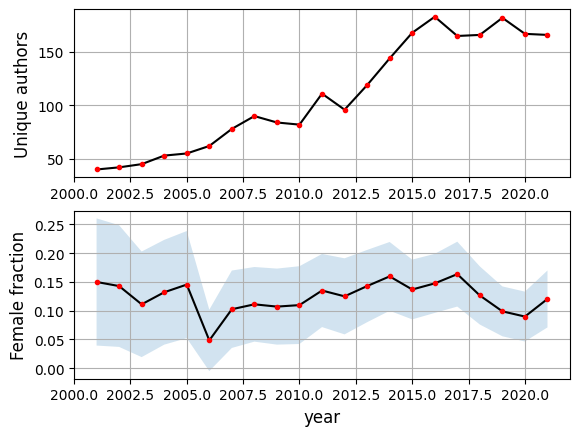

In [156]:
dy = plot_gender(dpups,ymin=2000)

In [170]:
kk = dpupp.drop_duplicates('author_id')
print(f'{round(fraction(kk),3)}  ± {round(margin_of_error(fraction(kk),kk.shape[0]),3)}')
(fraction(kk)-margin_of_error(fraction(kk),kk.shape[0]), 
 fraction(kk)+margin_of_error(fraction(kk),kk.shape[0]))

0.135  ± 0.017


(0.11754963116146488, 0.1521432927370665)

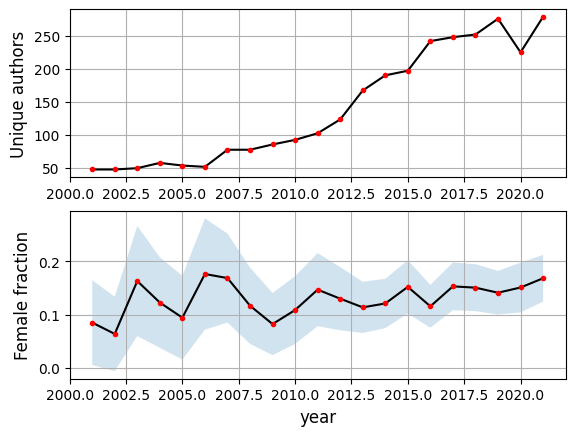

In [158]:
dy = plot_gender(dpupp,ymin=2000)

In [171]:
kk = dpupj.drop_duplicates('author_id')
print(f'{round(fraction(kk),3)}  ± {round(margin_of_error(fraction(kk),kk.shape[0]),3)}')
(fraction(kk)-margin_of_error(fraction(kk),kk.shape[0]), 
 fraction(kk)+margin_of_error(fraction(kk),kk.shape[0]))

0.125  ± 0.023


(0.1023081436824297, 0.14769185631757029)

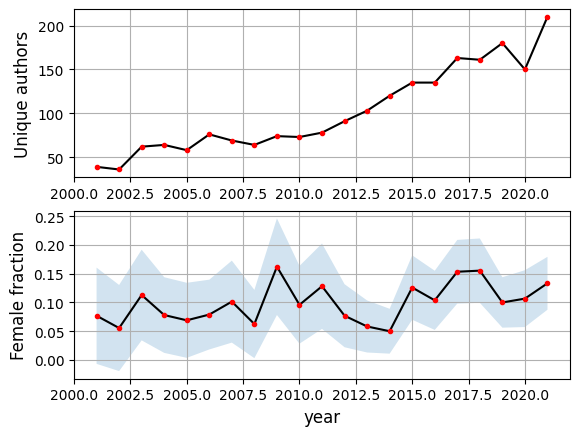

In [160]:
dy = plot_gender(dpupj,ymin=2000)

In [172]:
kk = dpupS.drop_duplicates('author_id')
print(f'{round(fraction(kk),3)}  ± {round(margin_of_error(fraction(kk),kk.shape[0]),3)}')
(fraction(kk)-margin_of_error(fraction(kk),kk.shape[0]), 
 fraction(kk)+margin_of_error(fraction(kk),kk.shape[0]))

0.079  ± 0.013


(0.06530428051045829, 0.0917308953689387)

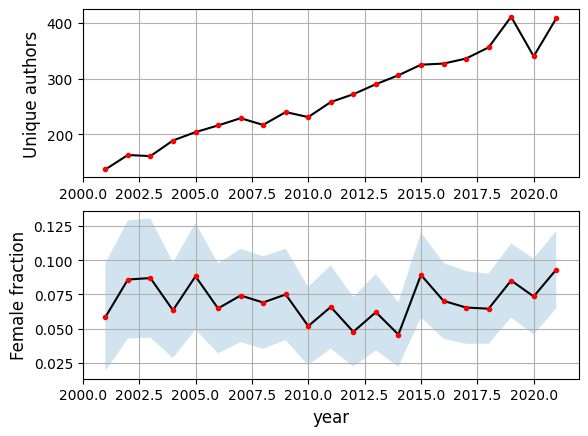

In [162]:
dy = plot_gender(dpupS,ymin=2000)

In [92]:
dpugf = dpu[dpu['gender']=='female'].reset_index(drop = True)

In [93]:
dpugf.shape

(7171, 22)

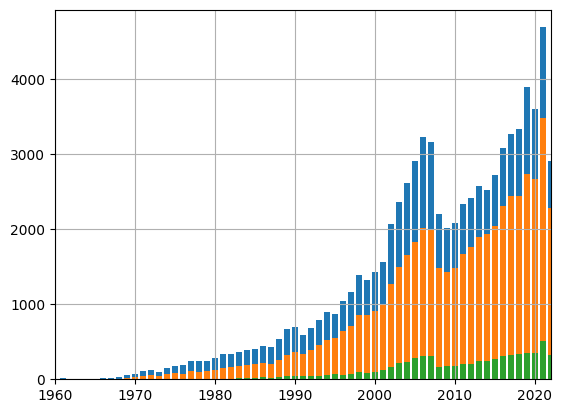

In [94]:
plt.bar( dpa[dpa['year']>0]['year'].replace('None',0).astype(int).value_counts().sort_index().to_dict().keys(),
        dpa[dpa['year']>0]['year'].replace('None',0).astype(int).value_counts().sort_index().to_dict().values())
plt.bar( dpu[dpu['year']>0]['year'].replace('None',0).astype(int).value_counts().sort_index().to_dict().keys(),
        dpu[dpu['year']>0]['year'].replace('None',0).astype(int).value_counts().sort_index().to_dict().values())
plt.bar( dpugf[dpugf['year']>0]['year'].replace('None',0).astype(int).value_counts().sort_index().to_dict().keys(),
        dpugf[dpugf['year']>0]['year'].replace('None',0).astype(int).value_counts().sort_index().to_dict().values())
plt.xlim(1960,2022)
plt.grid()

In [129]:
dpugf.shape[0] / dpu.shape[0]

0.12945445355092608

In [10]:
ff = dpug[(dpug['year'].astype(int)>1970) & (dpug['genders'].apply(lambda L: 'female' in L)) ]['year'
          ].value_counts().sort_index().to_dict()#.plot(kind='bar')

In [11]:
#  dpug[dpug.year.astype(int) == y].shape

In [12]:
dpug['year'].apply(int).iloc[0]

np.int64(2021)

In [13]:
dpug['year'] = dpug['year'].apply(int)

In [14]:
FF = {}
for y in sorted(dpug['year'].unique()): 
    Y = dpug[dpug['year'] == y] 
    FF[y] = Y[Y['genders'].apply(lambda L: 'female' in L)].shape[0] / dpug[dpug['year'] == y].shape[0]

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

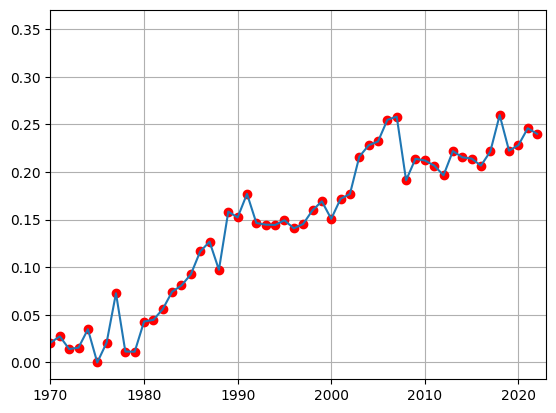

In [16]:
plt.plot(FF.keys(),FF.values(),'ro')
plt.plot(FF.keys(),FF.values())
plt.xlim(1970, 2023)
plt.grid()

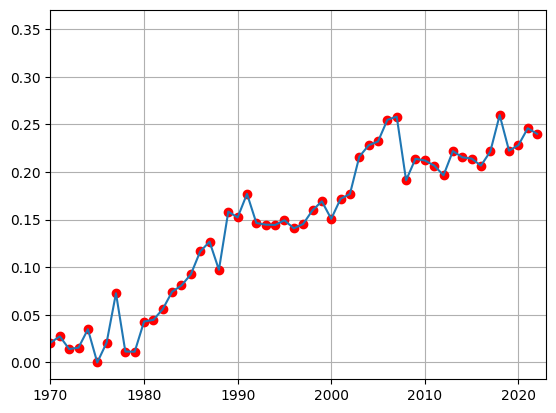

In [52]:
plt.plot(FF.keys(),FF.values(),'ro')
plt.plot(FF.keys(),FF.values())
plt.xlim(1970, 2023)
plt.grid()

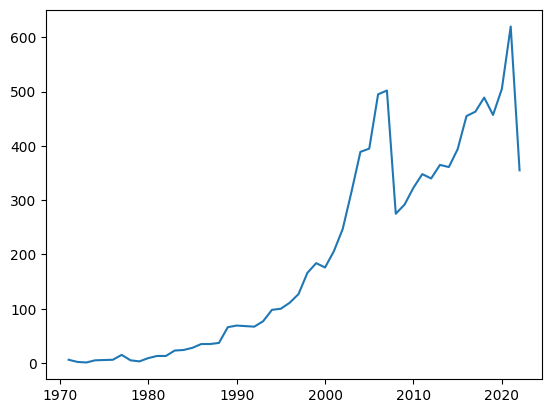

In [89]:
plt.plot([ int(y) for y in ff.keys()], ff.values())

In [ ]:
DF['first_names'] = DF.apply(lambda row: str(row['full_name']).split(', ')[-1]  
                             if row['first_names']=='None' 
                             else row['first_names'] ,axis = 'columns')

In [ ]:
DF['gender'].unique()

In [ ]:
print(DF['gender'].shape[0])
total = DF['gender'].dropna().shape[0]
total

In [ ]:
male = DF[DF['gender'] == 'male'].shape[0]
female = DF[DF['gender'] == 'female'].shape[0]
unknown = DF[DF['gender'] == 'unknown'].shape[0]
unknown = unknown + DF[DF['gender'] == 'andy'].shape[0]

In [ ]:
assert male + female + unknown == total

In [ ]:
male+female

In [ ]:
male

In [ ]:
female

In [ ]:
round(female/male,2)

In [ ]:
unknown

In [ ]:
DFFM = DF[ (( DF['gender'] == 'female') | ( DF['gender'] == 'male')) ]
DFFM.shape

In [ ]:
DFU = DF[ ~(( DF['gender'] == 'female') | ( DF['gender'] == 'male')) ]
DFU.shape

In [ ]:
DFFM[['author_id','first_names','country','gender']].sample(50)

In [ ]:
#[['first_names','country','gender']]
DFU.sample(50)[['author_id','full_name','name','country','gender']]

check specific entries

In [ ]:
JSON([d for d in df if d.get('author_id')=='F.Fontanot.3'][0])

In [ ]:
import requests
au = requests.get('https://inspirehep.net/api/authors?sort=bestmatch&size=250&page=1')
if au.status_code == 200:
    au = au.json()

In [ ]:
len(au['hits']['hits'])

In [ ]:
au['links']['next']

In [ ]:
# https://github.com/inspirehep/rest-api-doc/issues/20#issuecomment-997932079
url='https://inspirehep.net/api/authors?sort=bestmatch&size=250&page=1&q=control_number:[1+TO+2852058]'
au = requests.get(url)
if au.status_code == 200:
    au = au.json()

In [ ]:
len(au['hits']['hits'])

In [ ]:
au.status_code

In [ ]:
au = requests.get(url)

In [ ]:
step = 10000
ini = 981872
end = ini + step
for i in range(187):
    print(f'control_number:[{ini} TO {end}]')
    ini = end + 1
    end = ini + step

In [ ]:
au.status_code

In [ ]:
len(au.json()['hits']['hits'])

o